## Notebook for week 6
- For more information, refers to [the whole python notebook](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch02.ipynb)

- Importing necessary installation then we checking pytorch and tiktoken version.

In [1]:
import tiktoken
import torch
from importlib.metadata import version
from dataloader import create_dataloader_v1

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

- Importing the training data for the model. The model is [the full books of complete works and plays by William Shakespeare](https://shakespeare.mit.edu/)
- For my own personal research, I also divide the whole books into excerpts, each takes different part of the text with `excerpt3` is my favorite so far.

In [ ]:
with open("../data/The Complete Works of William Shakespeare.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
excerpt = raw_text[810:1000]
excerpt2 = raw_text[928:2000]
excerpt3 = raw_text[810:2000]

- Printing out each excerpt, only run this if necessary.

In [ ]:
print("Total number of characters:", len(raw_text))
print(excerpt)
print(excerpt2)
print(excerpt3)

- Initializing tokenizer and testing the token and the output strings.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
Id = tokenizer.encode(excerpt3)
print(Id)

strings = tokenizer.decode(Id)
print(strings)

- Testing how the decoder works following the Byte-pair encoding method of GPT-2(refers to the main notebook for more information but basically, GPT-2 divides each unknown words into subwords that contain fragments of that words to increase the chance of finding similarity). In this case, each tokens represents one letter.

In [ ]:
for i in range(10):
    decoded = tokenizer.decode(Id[:i+1])
    print(f"{Id[:i+1]} {decoded}")

- Adding some extra testing, only run this if it's necessary for understanding.

In [ ]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

strings = tokenizer.decode(integers)
print(strings)
print(len(Id))

- Creating a simple dataloader to start tokenizing the training data as tensor vectors and giving out results.

In [ ]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Inputs: \n", inputs)
print("Targets: \n", targets)

- Initializing variables ready for token embeddings and encoding words position.
- The BytePair encoder has a vocabulary size of 50,257.

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])
# vocab_size = 6
# output_dim = 3
vocab_size = 50257
output_dim = 256
max_length = 4

- This would results in a weight matrix that compared with the token ID, gives out a 3D weight vector for each of the token creates.
- For the last 2 print statement, printing the token with the respective ID will gives out a 3D weight vector correspond to that ID that's already initialize with `embedding_layer`, printing `input_ids` will gives out each 3D weight vector corresponding to each ID that's already in `embedding_layer` (See the comments).
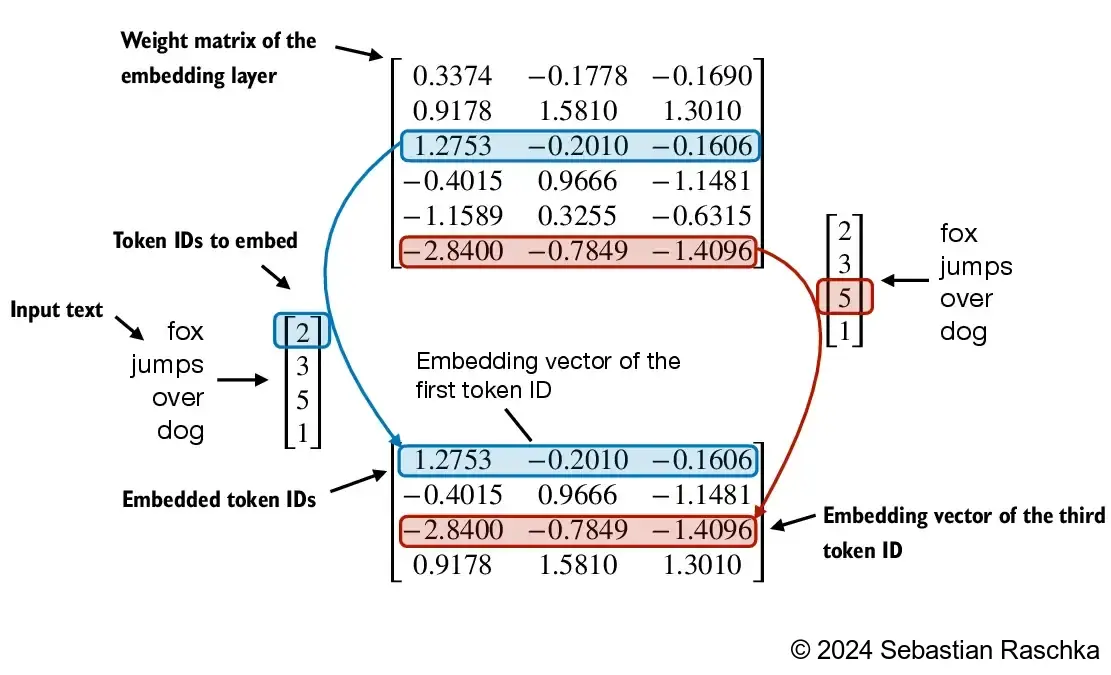
- It went through generalization by finding the ID that has been tokenize and checks the weight matrix to find the similarity inside. If there's no match then it'll either create one or based the tokenize of what it's already have like how GPT-2 works.
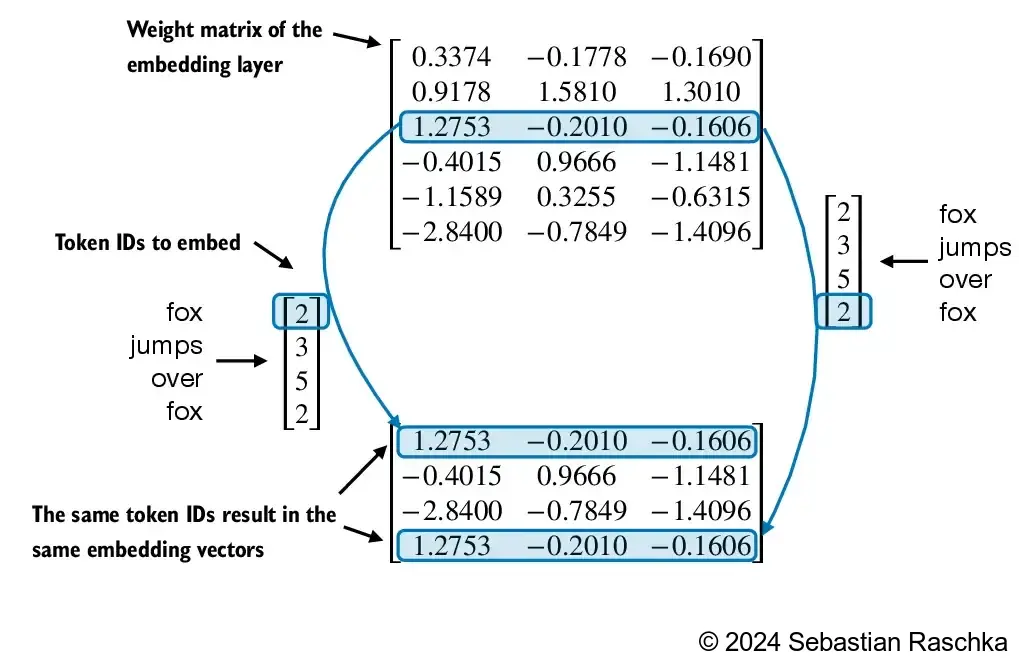

In [ ]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(embedding_layer.weight)
# Parameter containing:
# tensor([[ 0.3374, -0.1778, -0.1690],
#         [ 0.9178,  1.5810,  1.3010],
#         [ 1.2753, -0.2010, -0.1606],
#         [-0.4015,  0.9666, -1.1481],
#         [-1.1589,  0.3255, -0.6315],
#         [-2.8400, -0.7849, -1.4096]], requires_grad=True)

print(embedding_layer(torch.tensor([3])))
# tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)

print(embedding_layer(input_ids))
# tensor([[ 1.2753, -0.2010, -0.1606],
#         [-0.4015,  0.9666, -1.1481],
#         [-2.8400, -0.7849, -1.4096],
#         [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

- Creating `token_embeddings` logic based on what we did, embedding the whole dataloader with the weight matrix that bind each token to one weight.

In [ ]:
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embeddings = token_embedding_layer(inputs)    # *inputs*, targets = next(data_iter)

print(token_embeddings.shape)

- Creating `pos_embedding` logic based on each word position, the target is for the LLM to predict the next word, so word placement is very important, based of the placement in the weight matrix.

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))

print(pos_embeddings.shape)

- Adding `tokens_embeddings` and `pos_embeddings` together to create the main `input_embeddings`, waiting to be train.

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)